Thinking of APR. Are we doing the dual optimization with the classification model + the pertubation added?

1. Run BPR and retrieve the model parameters + predict with parameters
2. Create input output for adversary and train + save adversary
3. tune data with the discussed methodology

In [81]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
import utility
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
## time the process
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair)
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
        return u, i, j

## chunk to define matrix factorization part
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
        if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
            """Normal training"""
            loss.backward()
            return loss

        else:
            """Adversarial training:
                    1.Backward to get grads
                    2.Construct adversarial perturbation
                    3.Add adversarial perturbation to embeddings
                    4.Calculate APR loss
            """
            # Backward to get grads
            # this would be the part we change in defining delta, delta = HPN (phi)

            # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
            loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
            ##recheck this
            grad_u = u.grad
            grad_i = i.grad
            grad_j = j.grad

            # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
            if grad_u is not None:
                delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
            else:
                delta_u = torch.rand(u.size())
            if grad_i is not None:
                delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
            else:
                delta_i = torch.rand(i.size())
            if grad_j is not None:
                delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
            else:
                delta_j = torch.rand(j.size())

            # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
            x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
            x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

            # find difference between pos and neg item, then clip value
            x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)

            # Calculate APR loss with logsigmoid
            log_prob = F.logsigmoid(x_uij_adv).sum()
            adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
            adv_loss.backward()

            return adv_loss


In [124]:
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        #for all user
        for i in range(user_emb.shape[0]):
            #set helps to identify unique members in a list
            test = set(test_user_list[i])
            #top k item from prediction list
            pred = set(result[i, :k].numpy().tolist())
            #if topk lies on both test and pred list
            val = len(test & pred)
            #hit ratio = %item hit
            hr += val / max([len(test), 1])
            #convert pred back to list
            pred = list(pred)
            if test_user_list[i] == []:
                continue
            else:
                for x in test_user_list[i]:
                    x = int(x)
                    ## check if x is in the prediction where x = 1st member of user list
                    if pred.count(x) != 0:
                        position = pred.index(x)
                        ndcg += math.log(2) / math.log(position + 2) if position < k else 0
                    else:
                        ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs


In [128]:
with open('preprocessed/ml-1m-2.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [129]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)

# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = MF(user_size, item_size, 64, 0, 1, 0.5)

In [130]:
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000):
        loss = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                        model.H.detach(),
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr_manual'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr_manual')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:00
BPR-MF Epoch [20/1000]
loss: 354.8221
HR@50: 0.0327, HR@100: 0.0672, NDCG@50: 0.0827, NDCG@100: 0.0827
BPR-MF Epoch [40/1000]
loss: 354.7227
HR@50: 0.0331, HR@100: 0.0682, NDCG@50: 0.0825, NDCG@100: 0.0825
BPR-MF Epoch [60/1000]
loss: 354.8884
HR@50: 0.0336, HR@100: 0.0667, NDCG@50: 0.0847, NDCG@100: 0.0847
BPR-MF Epoch [80/1000]
loss: 354.8069
HR@50: 0.0336, HR@100: 0.0680, NDCG@50: 0.0865, NDCG@100: 0.0865
BPR-MF Epoch [100/1000]
loss: 354.6473
HR@50: 0.0336, HR@100: 0.0667, NDCG@50: 0.0896, NDCG@100: 0.0896
BPR-MF Epoch [120/1000]
loss: 354.8765
HR@50: 0.0357, HR@100: 0.0688, NDCG@50: 0.0937, NDCG@100: 0.0937
BPR-MF Epoch [140/1000]
loss: 354.6185
HR@50: 0.0385, HR@100: 0.0740, NDCG@50: 0.1001, NDCG@100: 0.1001
BPR-MF Epoch [160/1000]
loss: 354.3387
HR@50: 0.0420, HR@100: 0.0810, NDCG@50: 0.1124, NDCG@100: 0.1124
BPR-MF Epoch [180/1000]
loss: 354.3116
HR@50: 0.0481, HR@100: 0.0914, NDCG@50: 0.1299, NDCG@100: 0.1299
BPR-MF Epoch [200/1000]
loss: 353.4748
HR@50: 0.0576, H

for ml-1m-6 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939

for ml-1m-6 data set with continue + for loop for X in test user set , epoch 1000 has
loss: 196.0934
HR@50: 0.3266, HR@100: 0.4649, NDCG@50: 0.7004, NDCG@100: 0.7004


ml-1m normal dataset
loss: 150.8645
HR@50: 0.1437, HR@100: 0.2245, NDCG@50: 0.0365, NDCG@100: 0.0365

test ml-1m normal dataset with for loop for X in test user set
loss: 181.7949
HR@50: 0.1480, HR@100: 0.2252, NDCG@50: 0.0373, NDCG@100: 0.0373

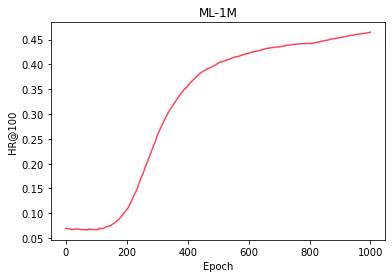

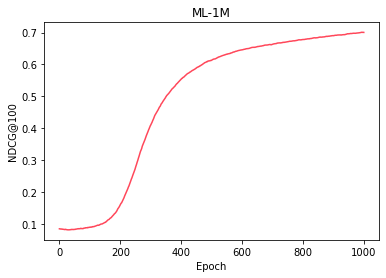

In [131]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()

Running a saving output of BPR model

Next up = train adversary based on fixed parameters of BPR

In [150]:
key_genre = pd.read_pickle(r'ml1m-6/key_genre.pkl')  
item_idd_genre_list = pd.read_pickle(r'ml1m-6/item_idd_genre_list.pkl')   
genre_item_vector = pd.read_pickle(r'ml1m-6/genre_item_vector.pkl')    
genre_count = pd.read_pickle(r'ml1m-6/genre_count.pkl')      
user_genre_count = pd.read_pickle(r'ml1m-6/user_genre_count.pkl') 

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)

In [219]:
item_genre_list = []
for u in range(num_item):
    gl = item_idd_genre_list[u]
    tmp = []
    for g in gl:
        if g in key_genre:
            tmp.append(g)
    item_genre_list.append(tmp)

item_genre = np.zeros((num_item, num_genre))
for i in range(num_item):
    gl = item_genre_list[i]
    for k in range(num_genre):
        if key_genre[k] in gl:
            item_genre[i, k] = 1.0

genre_count_mean_reciprocal = []
for k in key_genre:
    genre_count_mean_reciprocal.append(1.0 / genre_count[k])
genre_count_mean_reciprocal = (np.array(genre_count_mean_reciprocal)).reshape((num_genre, 1))
genre_error_weight = np.dot(item_genre, genre_count_mean_reciprocal)

In [220]:
item_genre

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [221]:
item_genre = torch.from_numpy(item_genre).type(torch.float)
item_genre.size()

torch.Size([1481, 6])

In [205]:
import random
 
# Function to generate
# and append them
# start = starting range,
# end = ending range
# num = number of
# elements needs to be appended
def Rand(start, end, num):
    res = []
 
    for j in range(num):
        res.append(random.randint(start, end))
 
    return res

In [194]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()




(torch.Size([6036, 64]), torch.Size([1481, 64]))

In [196]:
Rec = np.matmul(list(model1.items())[0][1], list(model1.items())[1][1].T)
Rec.size()
# Rec[1,:].size()


torch.Size([6036, 1481])

In [207]:
train_id = Rand(0,list(model1.items())[1][1].size()[0],1200)

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Rec.T, 
                                                    item_genre, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(1184, 297, 1184, 297)

In [248]:
#adv, linear-relu, linear-sigmoid last layer, numlayer = 4, 512,256,128,64 hidden units 

adversary = nn.Sequential(
    nn.Linear(list(model1.items())[0][1].size()[0], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 6),
    nn.Sigmoid()
)

In [249]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.CrossEntropyLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=adversary.parameters(), 
                            lr=0.00025)

In [250]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [265]:
torch.manual_seed(18)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    adversary.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = adversary(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round((y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    adversary.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = adversary(X_test).squeeze() 
        test_pred = torch.round((test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.15301, Accuracy: 282.77% | Test loss: 2.06401, Test acc: 275.42%
Epoch: 10 | Loss: 2.15295, Accuracy: 283.02% | Test loss: 2.06395, Test acc: 276.09%
Epoch: 20 | Loss: 2.15289, Accuracy: 283.36% | Test loss: 2.06388, Test acc: 276.77%
Epoch: 30 | Loss: 2.15283, Accuracy: 283.61% | Test loss: 2.06382, Test acc: 277.10%
Epoch: 40 | Loss: 2.15277, Accuracy: 284.54% | Test loss: 2.06376, Test acc: 277.44%
Epoch: 50 | Loss: 2.15271, Accuracy: 284.46% | Test loss: 2.06369, Test acc: 278.45%
Epoch: 60 | Loss: 2.15265, Accuracy: 284.88% | Test loss: 2.06363, Test acc: 279.46%
Epoch: 70 | Loss: 2.15259, Accuracy: 285.30% | Test loss: 2.06357, Test acc: 280.13%
Epoch: 80 | Loss: 2.15254, Accuracy: 286.15% | Test loss: 2.06351, Test acc: 280.47%
Epoch: 90 | Loss: 2.15248, Accuracy: 286.57% | Test loss: 2.06345, Test acc: 280.47%
Epoch: 100 | Loss: 2.15242, Accuracy: 287.25% | Test loss: 2.06339, Test acc: 281.82%
Epoch: 110 | Loss: 2.15236, Accuracy: 288.18% | Test loss: 2.0633

Epoch: 960 | Loss: 2.14821, Accuracy: 292.23% | Test loss: 2.05898, Test acc: 284.51%
Epoch: 970 | Loss: 2.14817, Accuracy: 291.64% | Test loss: 2.05894, Test acc: 283.16%
Epoch: 980 | Loss: 2.14812, Accuracy: 291.13% | Test loss: 2.05889, Test acc: 283.50%
Epoch: 990 | Loss: 2.14808, Accuracy: 289.95% | Test loss: 2.05885, Test acc: 281.48%
